In [74]:
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from sklearn import metrics

In [75]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [76]:
df = pd.read_csv(r'./features.csv', sep='\t', encoding='utf-8')

In [77]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [78]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 83, dtype: int64

In [79]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [80]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

In [81]:
corrdf = df.drop(columns=['datetime']).corr()

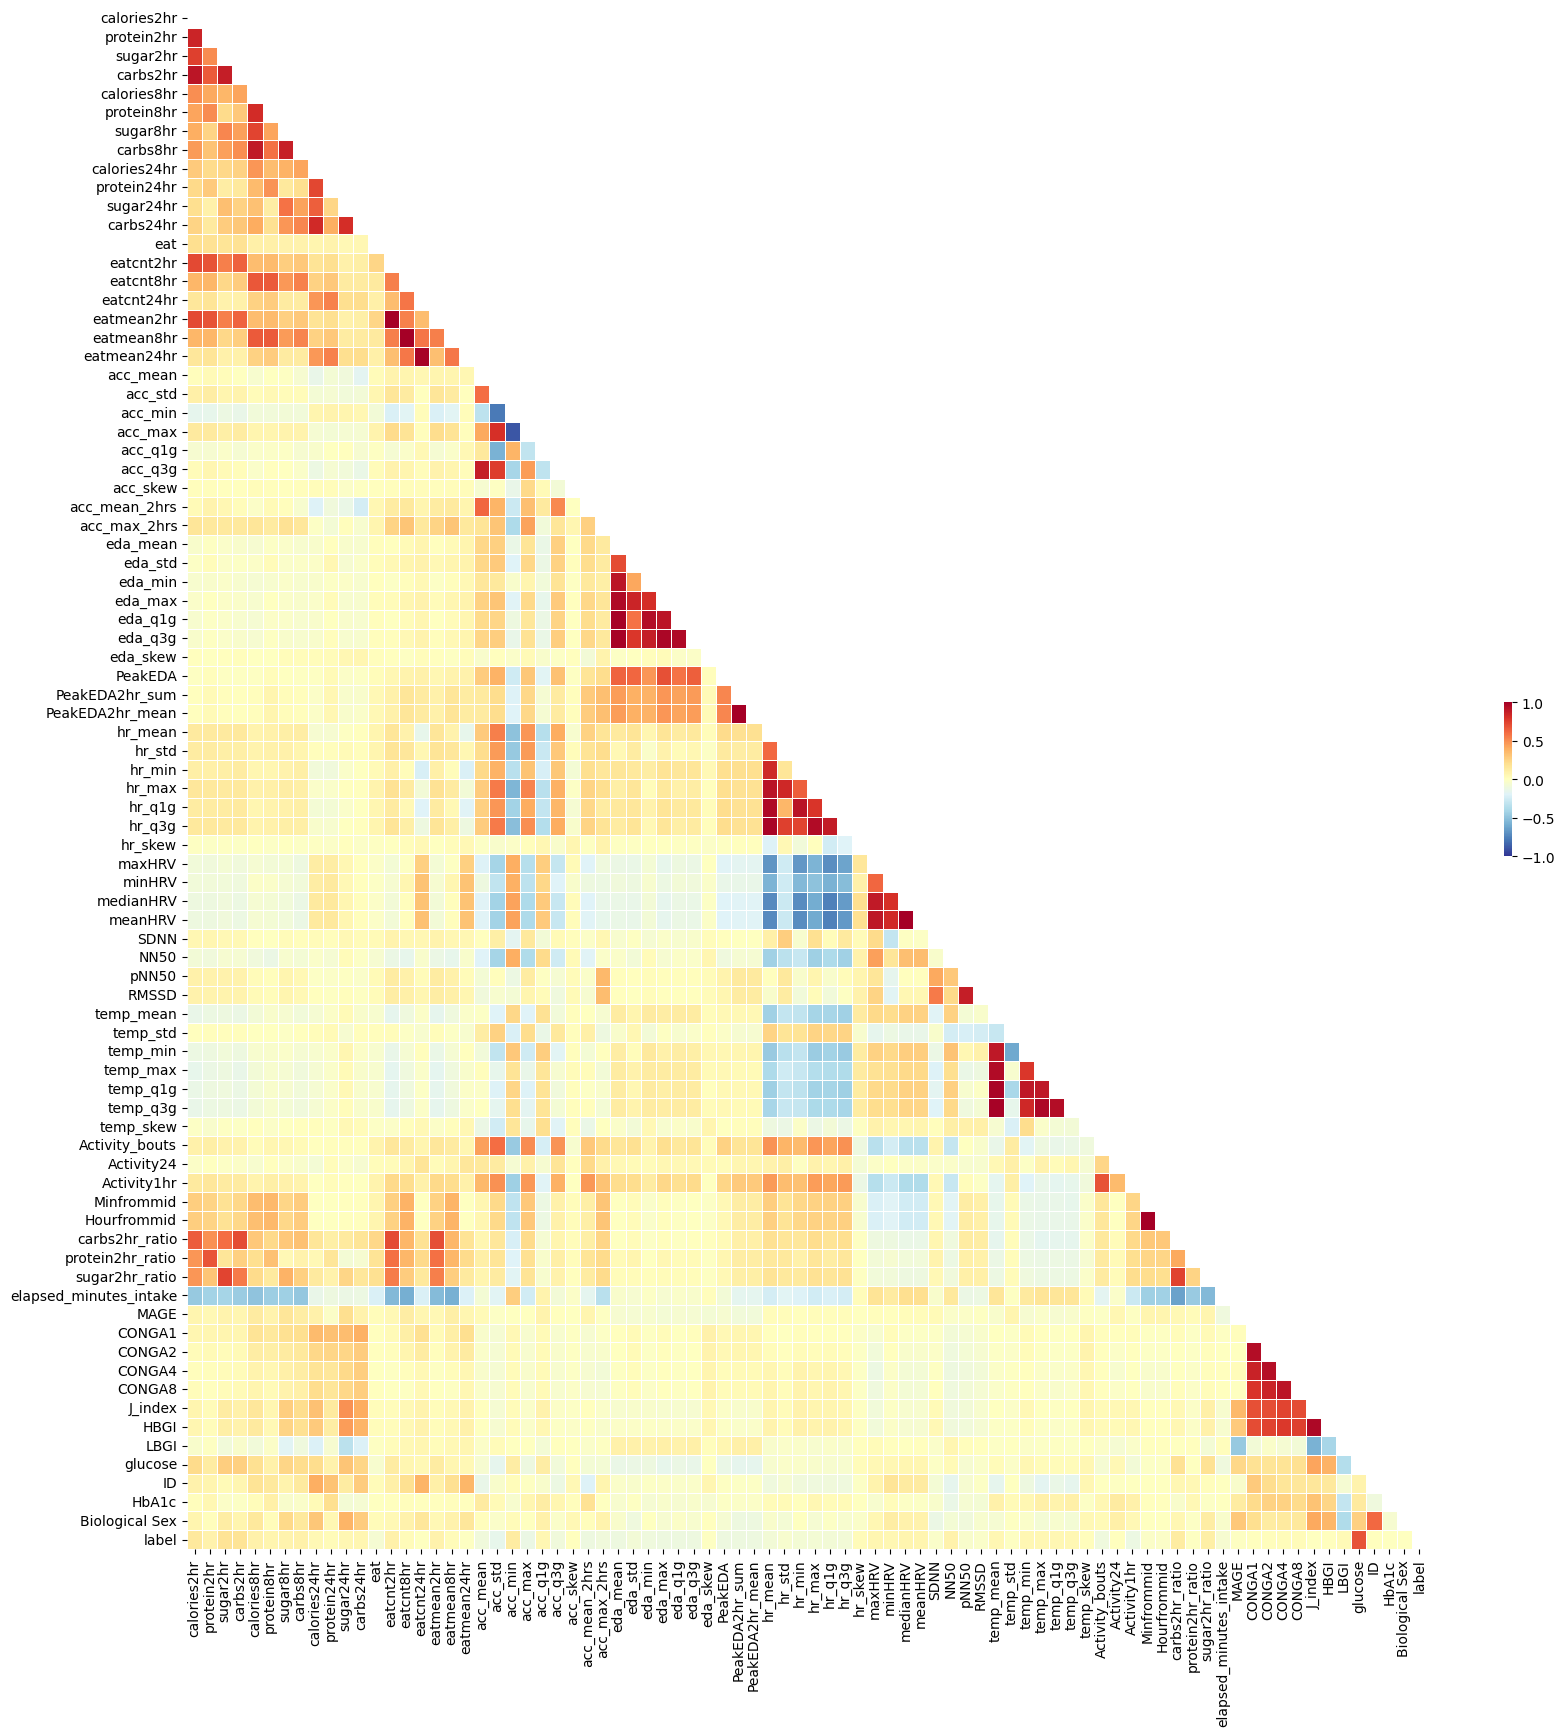

In [82]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

In [83]:
def XGBLOSO(data, ids, outcomevar, dropcols, idcolumn, param_grid, numestimators=1000):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)

    # Iterate over each parameter combination
    performance_df = pd.DataFrame()
    for params in ParameterGrid(param_grid):
        model = xgb.XGBRegressor(**params, random_state=0, enable_categorical=True)
        model.fit(X_train, y_train)
        
        test_predictions = model.predict(X_test)
        train_predictions = model.predict(X_train)
        
        # Root Mean Squared Error (RMSE)
        test_rmse = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
        train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
        
        # Mean Average Percent Error (MAPE)
        test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
        train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100

        # Record the performance metrics along with the model parameters
        new_row = pd.DataFrame({
            'id': [ids],
            'params': [str(params)],
            'train_rmse': [train_rmse],
            'test_rmse': [test_rmse],
            'train_mape': [train_mape],
            'test_mape': [test_mape]
        })

        # Concatenate the new row with the existing performance_df
        performance_df = pd.concat([performance_df, new_row], ignore_index=True)

    return performance_df

def losoXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'nthread':[4],
        'n_estimators': [100],
        #'n_estimators': [100, 500, 1000],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        "gamma":[ 0.0, 0.1, 0.2],
    }
    
    all_performance_df = pd.DataFrame()

    # Run LOOCV Random Forest! 
    for i in IDlist:
        performance_df = XGBLOSO(data, i, outcomevar, drop, idcolumn, param_grid, numestimators)
        all_performance_df = pd.concat([all_performance_df, performance_df], ignore_index=True)
        print('...' + str(i) + ' processing complete.')

    return all_performance_df

In [84]:
loso_all_performance_df = losoXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
...1.0 processing complete.
LOOCV_O : 2
...2.0 processing complete.
LOOCV_O : 3
...3.0 processing complete.
LOOCV_O : 4
...4.0 processing complete.
LOOCV_O : 5
...5.0 processing complete.
LOOCV_O : 6
...6.0 processing complete.
LOOCV_O : 7
...7.0 processing complete.
LOOCV_O : 8
...8.0 processing complete.
LOOCV_O : 9
...9.0 processing complete.
LOOCV_O : 10
...10.0 processing complete.
LOOCV_O : 11
...11.0 processing complete.
LOOCV_O : 12
...12.0 processing complete.
LOOCV_O : 13
...13.0 processing complete.
LOOCV_O : 14
...14.0 processing complete.
LOOCV_O : 16
...16.0 processing complete.


In [85]:
loso_all_performance_df.head(50)

,id,params,train_rmse,test_rmse,train_mape,test_mape
0,1.0,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",18.054918,14.881694,11.551066,11.517956
1,1.0,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",16.906478,14.907547,10.867798,11.581609
2,1.0,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep...",15.722716,15.005252,10.166739,11.660118
3,1.0,"{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",10.991117,15.399905,6.860435,11.432064
4,1.0,"{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",8.974079,14.994636,5.683028,11.183397
5,1.0,"{'gamma': 0.0, 'learning_rate': 0.1, 'max_dept...",7.188806,15.750395,4.608226,11.796810
6,1.0,"{'gamma': 0.0, 'learning_rate': 0.2, 'max_dept...",8.774508,15.938995,5.576397,12.030986
7,1.0,"{'gamma': 0.0, 'learning_rate': 0.2, 'max_dept...",7.013441,17.024844,4.509581,12.573732
8,1.0,"{'gamma': 0.0, 'learning_rate': 0.2, 'max_dept...",5.022842,15.957930,3.270537,12.127110
9,1.0,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_dep...",18.054918,14.881694,11.551066,11.517956


In [86]:
loso_all_performance_df.to_csv(r'./xgboost_loso_gridsearch_result.csv', sep='\t', encoding='utf-8', header='true')

## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [87]:
def XGBPartialPersonalization(data, ids, outcomevar, dropcols, idcolumn, param_grid, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test
    data_test = data_test.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Iterate over each parameter combination
    performance_df = pd.DataFrame()
    for params in ParameterGrid(param_grid):
        model = xgb.XGBRegressor(**params, random_state=0, enable_categorical=True)
        model.fit(X_train, y_train)
        
        test_predictions = model.predict(X_test)
        train_predictions = model.predict(X_train)
        
        # Root Mean Squared Error (RMSE)
        test_rmse = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
        train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
        
        # Mean Average Percent Error (MAPE)
        test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
        train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100

        # Record the performance metrics along with the model parameters
        new_row = pd.DataFrame({
            'id': [ids],
            'params': [str(params)],
            'train_rmse': [train_rmse],
            'test_rmse': [test_rmse],
            'train_mape': [train_mape],
            'test_mape': [test_mape]
        })

        # Concatenate the new row with the existing performance_df
        performance_df = pd.concat([performance_df, new_row], ignore_index=True)

    return performance_df


def partialPersonalizationXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, personalization_train_percent = 0.5):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols

    # Define parameter grid for GridSearchCV
    param_grid = {
        'nthread':[4],
        'n_estimators': [100],
        #'n_estimators': [100, 500, 1000],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        "gamma":[ 0.0, 0.1, 0.2],
    }

    all_performance_df = pd.DataFrame()
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        performance_df = XGBPartialPersonalization(data, i, outcomevar, drop, idcolumn, param_grid, numestimators, personalization_train_percent)
        all_performance_df = pd.concat([all_performance_df, performance_df], ignore_index=True)
        print('...' + str(i) + ' processing complete.')
    
    return all_performance_df

In [88]:
pp_all_performance_df = partialPersonalizationXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['datetime'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
...1.0 processing complete.
LOOCV_O : 2
...2.0 processing complete.
LOOCV_O : 3
...3.0 processing complete.
LOOCV_O : 4
...4.0 processing complete.
LOOCV_O : 5
...5.0 processing complete.
LOOCV_O : 6
...6.0 processing complete.
LOOCV_O : 7
...7.0 processing complete.
LOOCV_O : 8
...8.0 processing complete.
LOOCV_O : 9
...9.0 processing complete.
LOOCV_O : 10
...10.0 processing complete.
LOOCV_O : 11
...11.0 processing complete.
LOOCV_O : 12
...12.0 processing complete.
LOOCV_O : 13
...13.0 processing complete.
LOOCV_O : 14
...14.0 processing complete.
LOOCV_O : 16
...16.0 processing complete.


In [89]:
pp_all_performance_df.to_csv(r'./xgboost_pp_gridsearch_result.csv', sep='\t', encoding='utf-8', header='true')